In [1]:
using Turing, Random, LinearAlgebra, Plots, Flux.Optimise, DelimitedFiles, DataFrames, Bijectors
using Turing: Variational
using Bijectors: Scale, Shift
using AdvancedVI
using ComponentArrays, UnPack
using ReverseDiff, Memoization

Random.seed!(1234);
Turing.setadbackend(:reversediff);
Turing.setrdcache(true);

# Dataset

In [2]:
sensors = readdlm("sensors.txt")
sensor1, sensor2, sensor3 = sensors[1,:], sensors[2,:], sensors[3,:]
observation = readdlm("observation.txt")
position = readdlm("position.txt")
#T = size(observation)[1]
T = 15
observation_list = []
for t=1:T
    push!(observation_list, observation[t,:])
end

# Model Specification

In [3]:
# Newtonian dynamics assumption
A = [1. 0. 1. 0.; 0. 1. 0. 1.; 0. 0. 1. 0.; 0. 0. 0. 1.]
B = [1. 0. 0. 0.; 0. 1. 0. 0.]
;

In [4]:
# Nonlinear function that maps states to observations
function f(z)       
    pos = B*z
    o1 = sqrt(sum((pos-sensor1).^2))
    o2 = sqrt(sum((pos-sensor2).^2))
    o3 = sqrt(sum((pos-sensor3).^2))
    o = [o1,o2,o3]
end

f (generic function with 1 method)

In [5]:
@model function model(y)
    W, R = diagm(0=>ones(4)), diagm(0=>ones(3))
    z = Vector{Vector}(undef, T)
    
    z[1] ~ MvNormal(zeros(4), diagm(0=>ones(4)))
    y[1] ~ MvNormal(f(z[1]), R)
    
    for t=2:T
        z[t] ~ MvNormal(A*z[t-1],W)
        y[t] ~ MvNormal(f(z[t]),R)
    end
end;

In [6]:
m = model(observation_list);

In [7]:
d = T*4
base_dist = Turing.DistributionsAD.TuringDiagMvNormal(zeros(d), ones(d));

In [8]:
to_constrained = inv(bijector(m));

In [9]:
proto_arr = ComponentArray(
    L = zeros(d, d),
    b = zeros(d)
)
proto_axes = proto_arr |> getaxes
num_params = length(proto_arr)

function getq(θ)
    L, b = begin
        @unpack L, b = ComponentArray(θ, proto_axes)
        LowerTriangular(L), b
    end
    # For this to represent a covariance matrix we need to ensure that the diagonal is positive.
    # We can enforce this by zeroing out the diagonal and then adding back the diagonal exponentiated.
    D = Diagonal(diag(L))
    A = L - D + exp(D) # exp for Diagonal is the same as exponentiating only the diagonal entries
    
    b = to_constrained ∘ Shift(b; dim = Val(1)) ∘ Scale(A; dim = Val(1))
    
    return transformed(base_dist, b)
end

getq (generic function with 1 method)

In [10]:
advi = ADVI(1, 6000)

ADVI{ReverseDiffAD{false}}(1, 6000)

In [11]:
# q_full_normal = vi(m, advi, getq, randn(num_params); optimizer = Descent(0.1)); # returns NaN
q_full_normal = vi(m, advi, getq, randn(num_params));

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 4880532330449873773
└ @ AdvancedVI /Users/sakbayrak/.julia/packages/AdvancedVI/yCVq7/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:00:42


In [12]:
-AdvancedVI.elbo(advi, q_full_normal, m, 1000)

104.72629568015384

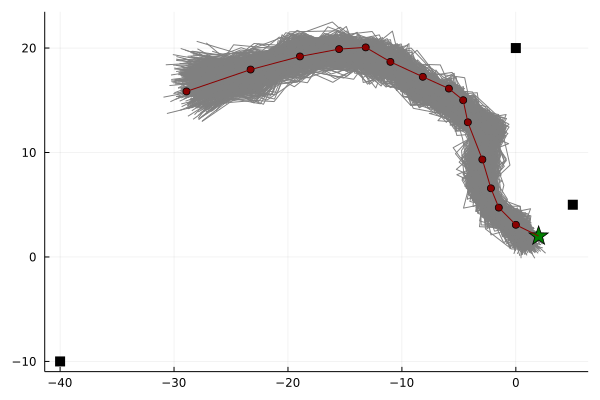

In [13]:
Estimations_samples = []
for s=1:1000
    Estimations = zeros(2,T)
    for t=1:T
        Estimations[:,t] = rand(q_full_normal)[4*(t-1)+1:4*(t-1)+2]
    end
    push!(Estimations_samples,Estimations)
end

plot(Estimations_samples[1][1,:],Estimations_samples[1][2,:],color=:grey, alfa=0.1)
for s=2:1000
    Estimations = Estimations_samples[s]
    plot!(Estimations[1,:],Estimations[2,:],color=:grey, alfa=0.1)
end
plot!([sensor1[1],sensor2[1],sensor3[1]],[sensor1[2],sensor2[2],sensor3[2]],seriestype = :scatter,color=:black, markersize=5, markershape=:square)
plot!(position[1,1:T],position[2,1:T], seriestype = :scatter,color=:redsblues)
scatter!((position[1,1],position[2,1]), color=:green, markershape=:star5, markersize=10)
plot!(position[1,1:T],position[2,1:T],color=:redsblues, legend=false)